In [1]:
# Import pandas as change max columns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer


## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib


## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)
## set pandas to display more columns
pd.set_option('display.max_columns',50)

In [3]:
import joblib
loaded = joblib.load('sales_prediction_models.joblib')
loaded.keys()

dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'LinearRegression', 'RandomForest'])

In [4]:
X_train_df = loaded['X_train']
y_train = loaded['y_train']
X_test_df = loaded['X_test']
y_test = loaded['y_test']
lin_reg = loaded['LinearRegression']
rand_forest = loaded['RandomForest']

## SHAP

In [5]:
# Import shap and initialize javascript:
import shap
shap.initjs()

In [6]:
len(X_train_df)

6392

In [7]:
X_shap = shap.sample(X_train_df,nsamples=400,random_state=321)
X_shap.head()

Item_Weight  Item_Visibility  Item_MRP  Outlet_Establishment_Year  \
3888        15.85         0.110653   36.9506                     2007.0   
2497        15.10         0.087407  221.8456                     1997.0   
7723        17.50         0.015592  184.8266                     2002.0   
8117        10.80         0.049820  243.2144                     2002.0   
7475        15.00         0.044999  140.4838                     2002.0   

      Item_Fat_Content_Regular  Outlet_Size_MISSING  Outlet_Size_Medium  \
3888                       1.0                  1.0                 0.0   
2497                       1.0                  0.0                 0.0   
7723                       0.0                  1.0                 0.0   
8117                       0.0                  1.0                 0.0   
7475                       0.0                  1.0                 0.0   

      Outlet_Size_Small  Outlet_Location_Type_Tier 2  \
3888                0.0                          1.0   
2497                1.0                          0.0   
7723                0.0                          1.0   
8117                0.0                          1.0   
7475                0.0                          1.0   

      Outlet_Location_Type_Tier 3  Outlet_Type_Supermarket Type1  \
3888                          0.0                            1.0   
2497                          0.0                            1.0   
7723                          0.0                            1.0   
8117                          0.0                            1.0   
7475                          0.0                            1.0   

      Outlet_Type_Supermarket Type2  Outlet_Type_Supermarket Type3  
3888                            0.0                            0.0  
2497                            0.0                            0.0  
7723                            0.0                            0.0  
8117                            0.0                            0.0  
7475                            0.0                            0.0

In [8]:
## get the corresponding y-values
y_shap = y_train.loc[X_shap.index]
y_shap 

3888     759.0120
2497     663.1368
7723    2766.3990
8117    1225.0720
7475    1685.8056
          ...    
292     1379.5376
3035    2956.1520
6832    1259.6936
8455    4206.5244
7795     605.8780
Name: Item_Outlet_Sales, Length: 400, dtype: float64

In [9]:
## Resetting the index for sampled data to match shap_values integer index
X_shap = X_shap.reset_index(drop=True)
y_shap = y_shap.reset_index(drop=True)

## Random Forest

In [55]:
## fit random forest
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train_df,y_train)
print(f"Training R^2: {rf_reg.score(X_train_df,y_train):.3f}")
print(f"Test R^2: {rf_reg.score(X_test_df, y_test):.3f}")

Training R^2: 0.938
Test R^2: 0.549


### Create a model explainer


In [10]:
explainer = shap.Explainer(rand_forest)
explainer

In [11]:
## Getting the shap values
shap_values = explainer(X_shap,y_shap)
type(shap_values)

shap._explanation.Explanation

In [12]:
X_shap.shape


(400, 13)

In [13]:
shap_values.shape

(400, 13)

In [14]:
shap_values[0]

.values =
array([-2.46033433e-01, -7.00673146e+00, -1.66776412e+03,  5.84081851e+01,
        7.11504371e+00, -5.70440376e+00, -2.64823604e+01, -5.49350072e-01,
       -1.78621581e+00, -1.04122544e+00,  2.02894039e+02, -2.21704533e+01,
       -1.00720263e+02])

.base_values =
array([2207.5242624])

.data =
array([1.58500000e+01, 1.10653377e-01, 3.69506000e+01, 2.00700000e+03,
       1.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
       0.00000000e+00])

### Bar Plot

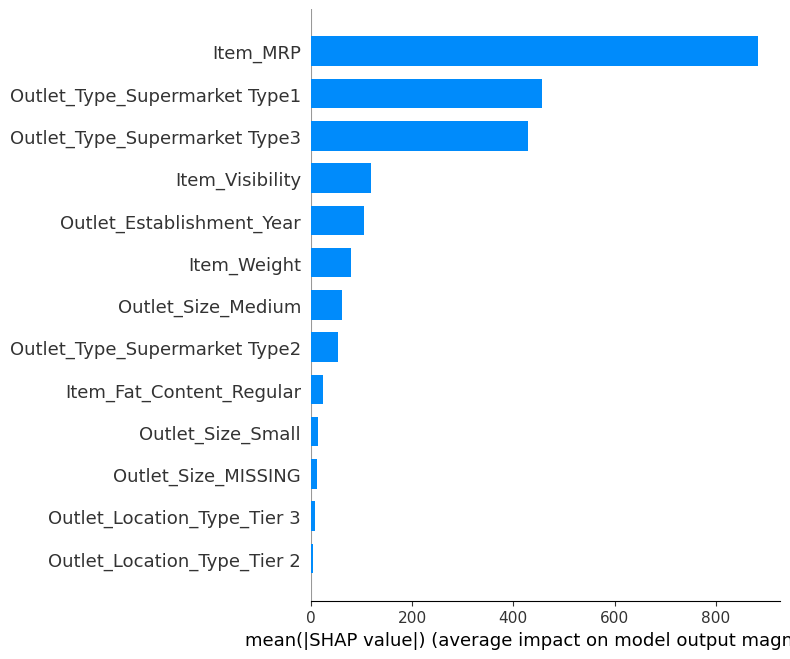

In [15]:
shap.summary_plot(shap_values,features= X_shap, plot_type='bar')

### Feature Importance

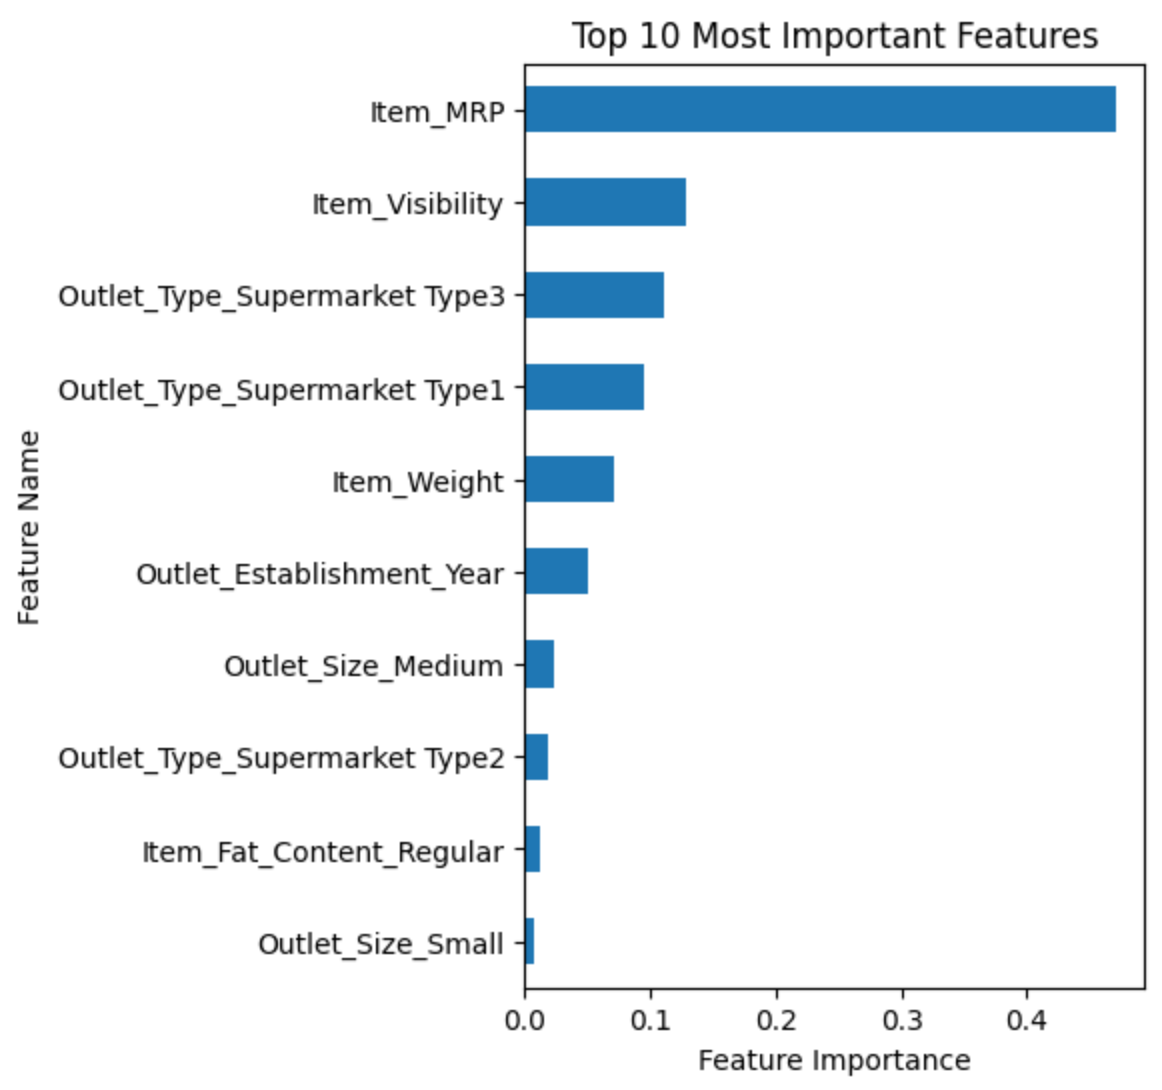




The most important features according to SHAP and the original feature importances differ. The top 5 most important features according to SHAP are Item_MRP, Outlet_Type_SuperMarket Type1, Outlet_Type_SuperMarket Type3, Item_Visibility, and Outlet_Establishment_Year.

According to our original important features, the most important features are Item_MRP, Item_Visibility, Outlet_Type_SuperMarket Type 3, Outlet_Type_SuperMarket Type1, and Item_Weight.

The only similiarity between the two is Item_MRP being the most important

### Dot Plot

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


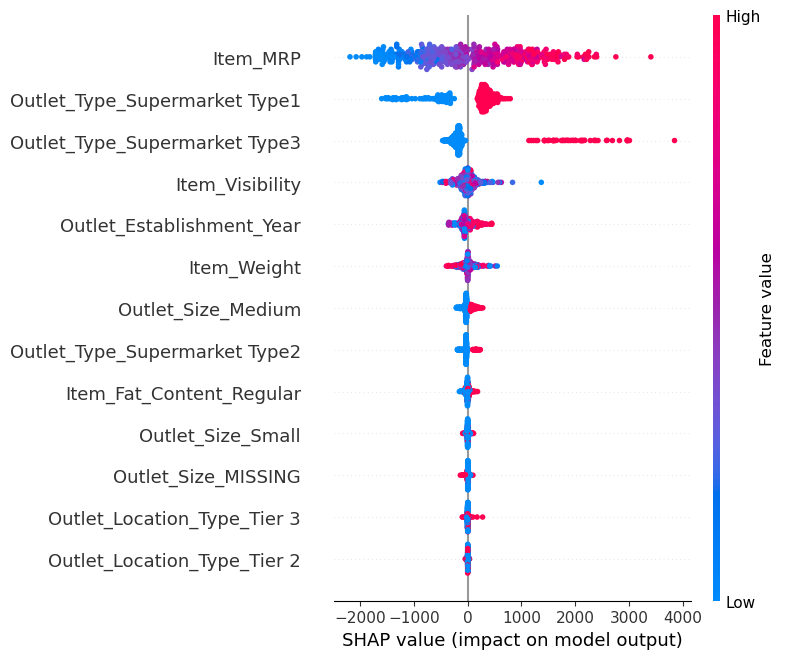

In [16]:
shap.summary_plot(shap_values,X_shap)

Item_MRP is the Maximum Retail Price (list price) of the product. The plot is pretty consistent with there being a relatively equal amount of high and low feature values for Item_MRP. This could inidcate that a higher MRP leads to a higher impact on Sales of Items.

Outlet_Type_SuperMarket Type1 tells us that there is a higher Sales Output Items sold in Outlet_Type_SuperMarket Type1. 

This is more evident Outlet_Type_SuperMarket Type3 since there is a greater difference between high and low features.



In [17]:
## Global Force Plot 
shap.force_plot(explainer.expected_value, shap_values.values, features=X_shap)

# Local Explanations

## Select Feature

### Visibility

<Axes: xlabel='Item_Visibility', ylabel='Count'>

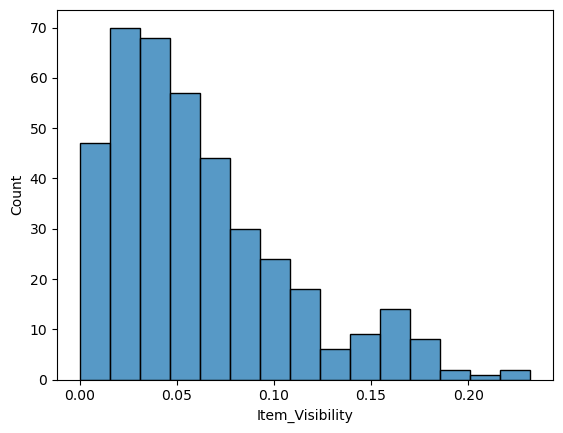

In [18]:
sns.histplot(X_shap['Item_Visibility'])


In [19]:
X_shap['Item_Visibility'].agg(['mean','median'])


mean      0.061463
median    0.050095
Name: Item_Visibility, dtype: float64

In [20]:
## Finding number of stores with visibiltiy of product above 0.15
above_avg_visible = X_shap['Item_Visibility'] > 0.15
len(X_shap[above_avg_visible])

30

### SuperMarket Type 1

<Axes: xlabel='Outlet_Type_Supermarket Type1', ylabel='Count'>

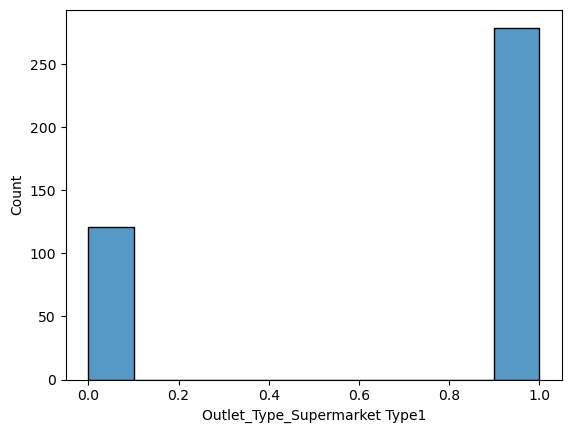

In [21]:
sns.histplot(X_shap['Outlet_Type_Supermarket Type1'])


In [22]:
## Finding number of stores Outlet_Type_Supermarket Type1 == 1
outlet_type_1 = X_shap['Outlet_Type_Supermarket Type1'] == 1
len(X_shap[outlet_type_1])

279

In [23]:
## Finding number of stores Outlet_Type_Supermarket Type1 == 0
non_outlet_type_1 = X_shap['Outlet_Type_Supermarket Type1'] == 0
len(X_shap[non_outlet_type_1])

121

In [24]:
len(X_shap[ outlet_type_1 & above_avg_visible ])

22

In [25]:
len(X_shap[ non_outlet_type_1 & above_avg_visible ])

8

## Defining Our Example Groups


* Both Groups:
    * Have above average Visibilty of Products
    
* Outlet Type 1:
Stores that are Outlet Type 1
* Non Outlet Type 1:
Stores that are not Outlet Type 1


I am curious to see how above Item Visibility of products impacts Sales Price for Outlet Type 1 Stores. I want to see if the Outlet Type 1 really affects sales price and so I want the Visibility of the product to be above average so that remains a constant between Outlet Type 1 stores and non Outlet Type 1 stores. 


In [26]:
lowest_value = np.median(y_shap)
lowest_value

1851.5898

In [27]:
high_sales = y_shap > 2000
low_sales = y_shap < 1000

## High Sales

In [28]:
## Get filter for Outlet 
filt_type1_high_sales = outlet_type_1 & above_avg_visible & high_sales
filt_type1_high_sales.sum()



11

In [29]:
## Get filter for nonoutlet_type1 with high sales
filt_nontype1_high_sales = non_outlet_type_1 & above_avg_visible & high_sales
filt_nontype1_high_sales.sum()

1

## Low Sales

In [30]:
## Get filter for Outlet 
filt_type1_low_sales = outlet_type_1 & above_avg_visible & low_sales
filt_type1_low_sales.sum()


1

In [31]:
## Get filter for nonoutlet_type1 with high sales
filt_nontype1_low_sales = non_outlet_type_1 & above_avg_visible & low_sales
filt_nontype1_low_sales.sum()

6

# Group Outlet Type1 : High Sales

In [60]:
idx_examples_grp_type1_Sales = X_shap[filt_type1_high_sales].index
idx_examples_grp_type1_Sales

Int64Index([81, 107, 135, 206, 211, 220, 234, 276, 334, 339, 353], dtype='int64')

In [38]:
## selecting index of final example
i_grp_type1_high = 81 

In [39]:
## Individual forceplot
shap.force_plot(explainer.expected_value,
                shap_values= shap_values[i_grp_type1_high].values,
               features=X_shap.iloc[i_grp_type1_high])

As you can see, Item_MRP, Outlet_Type_Supermarket Type1 are the two prominent facotrs that led to a higher Sales Price. However, Outlet_Type_Supermarket Type3 seems to be the biggest factor to lower the sales price.

# Group Non Outlet Type1 : High Sales

In [40]:
idx_examples_grp_non_type1_Sales = X_shap[filt_nontype1_high_sales].index
idx_examples_grp_non_type1_Sales

Int64Index([363], dtype='int64')

In [41]:
## selecting index of final example
i_grp_non_high = 363 

In [46]:
## Individual forceplot
shap.force_plot(explainer.expected_value,
                shap_values= shap_values[i_grp_non_high].values,
               features=X_shap.iloc[i_grp_non_high])

The only factor that increased the sales is the Outlet Type Being Type 3. This was also the factor that lowered the above force plot. The Outlet Type 1 seems to have lowered the Sales and so this might tell us that Type 3 Supermarkets have the highest sales.

# Group Outlet Type1 : Low Sales

In [42]:
idx_examples_grp_type1_Low = X_shap[filt_type1_low_sales].index
idx_examples_grp_type1_Low

Int64Index([313], dtype='int64')

In [48]:
## selecting index of final example
i_grp_type1_low = 313 

In [49]:
## Individual forceplot
shap.force_plot(explainer.expected_value,
                shap_values= shap_values[i_grp_type1_low].values,
               features=X_shap.iloc[i_grp_type1_low])

According to this plot the only factor that contributed to a higher sales price is Outlet_Type_Supermaket Type 1. However the Item_MRP greatly impacted the sales, bringing it down.

# Group Non Outlet Type1 : Low Sales

In [50]:
idx_examples_grp_nontype1_Low = X_shap[filt_nontype1_low_sales].index
idx_examples_grp_nontype1_Low

Int64Index([89, 104, 250, 269, 291, 373], dtype='int64')

In [51]:
## selecting index of final example
i_grp_non_low = 89

In [52]:
## Individual forceplot
shap.force_plot(explainer.expected_value,
                shap_values= shap_values[i_grp_non_low].values,
               features=X_shap.iloc[i_grp_non_low])

Here, Item_MRP is the only factor that is contributing to a higher sales. However interestingly enough Outlet_Type_Supermarket Type 1 and Outlet_Type_Supermarket Type 3 being 0 were the biggest factors that brought sales down.

## Lime Plot

In [53]:
from lime.lime_tabular import LimeTabularExplainer
lime_explainer =LimeTabularExplainer(training_data=X_shap.values, feature_names=X_shap.columns, mode='regression')
lime_explainer

### Group Outlet Type1 : High Sales

In [56]:
exp = lime_explainer.explain_instance(X_shap.iloc[i_grp_type1_high],
                               rf_reg.predict)
exp.show_in_notebook()

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


The primary negative factor that brings down the sales is the fact Outlet_Type Supermarket is not Type 3. In contrast Outlet_Type Supermarket Type 1 is the biggest factor that increased the sales price.

### Group Non Outlet Type1 : High Sales

In [57]:
exp = lime_explainer.explain_instance(X_shap.iloc[i_grp_non_high],
                               rf_reg.predict)
exp.show_in_notebook()

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


Here, we have the exact opposite of the aboves plots primary facotrs affecting the prediciton. The OUtlet Type1 being 0 greatly hurt the sales, however the Outlet Type3 being 1 increased the Sales alot. This shows the impact these two metrics have on sales and howmuch the type of outlet affects the sales.

### Group Outlet Type1 : Low Sales

In [58]:
exp = lime_explainer.explain_instance(X_shap.iloc[i_grp_type1_low],
                               rf_reg.predict)
exp.show_in_notebook()

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


In this plot the Item_MRP stands out as it is lower than 98.82 which brings down Sales. Once again the Outlet Type affects the sales greatly.

### Group Non Outlet Type1 : Low Sales

In [59]:
exp = lime_explainer.explain_instance(X_shap.iloc[i_grp_non_low],
                               rf_reg.predict)
exp.show_in_notebook()

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


Here, we have an outlet type that is neither Type 1 or Type 3 and this greatly hurts the sales. The only positve factor is the Item_MRP.